#### Step 1: Import the data from the given Google_Stock_Price_Train-1.csv file

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv("Google_Stock_Price_Train-1.csv")
print('Number of rows and columns:', df.shape)
df.head(5)

Number of rows and columns: (1258, 6)


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# Sort by date
df = df.sort_values('Date')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
df['Close'] = df['Close'].str.replace(',', '').astype(float)

In [7]:
# Preprocess 'Volume' column: remove commas and convert to integer
df['Volume'] = df['Volume'].str.replace(',', '').astype(float)

# Drop 'Date' column (optional, as it is not used for prediction)
df = df.drop(columns=['Date', 'Volume'])

In [8]:
df.head()

,Open,High,Low,Close
0,325.25,332.83,324.97,663.59
1,331.27,333.87,329.08,666.45
2,329.83,330.75,326.89,657.21
3,328.34,328.77,323.68,648.24
4,322.04,322.29,309.46,620.76


In [9]:
df.dtypes

Open     float64
High     float64
Low      float64
Close    float64
dtype: object

In [10]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(df)

In [11]:
# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

In [12]:
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

In [13]:
# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Split into training and test sets (80% train, 20% test)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### Define the LSTM model

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

In [15]:
print(X.shape[2])

4


In [16]:
input_size = X.shape[2]  # Number of features (Open, High, Low, Close)
hidden_size = 50
num_layers = 4
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

### Train the Model

In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
model.train()

for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 0.0015
Epoch [20/100], Loss: 0.0012
Epoch [30/100], Loss: 0.0011
Epoch [40/100], Loss: 0.0008
Epoch [50/100], Loss: 0.0013
Epoch [60/100], Loss: 0.0004
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0005
Epoch [90/100], Loss: 0.0011
Epoch [100/100], Loss: 0.0005


### Predict and Evaluate the model

In [19]:
# Make predictions
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)

# Inverse transform to get actual prices
y_train_pred = sc.inverse_transform(np.concatenate((y_train_pred.detach().numpy(), np.zeros((y_train_pred.shape[0], df.shape[1]-1))), axis=1))[:,0]
y_test_pred = sc.inverse_transform(np.concatenate((y_test_pred.detach().numpy(), np.zeros((y_test_pred.shape[0], df.shape[1]-1))), axis=1))[:,0]
y_train_actual = sc.inverse_transform(np.concatenate((y_train.detach().numpy(), np.zeros((y_train.shape[0], df.shape[1]-1))), axis=1))[:,0]
y_test_actual = sc.inverse_transform(np.concatenate((y_test.detach().numpy(), np.zeros((y_test.shape[0], df.shape[1]-1))), axis=1))[:,0]


# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')




Train RMSE: 7.40
Test RMSE: 13.15


### Visualising the results

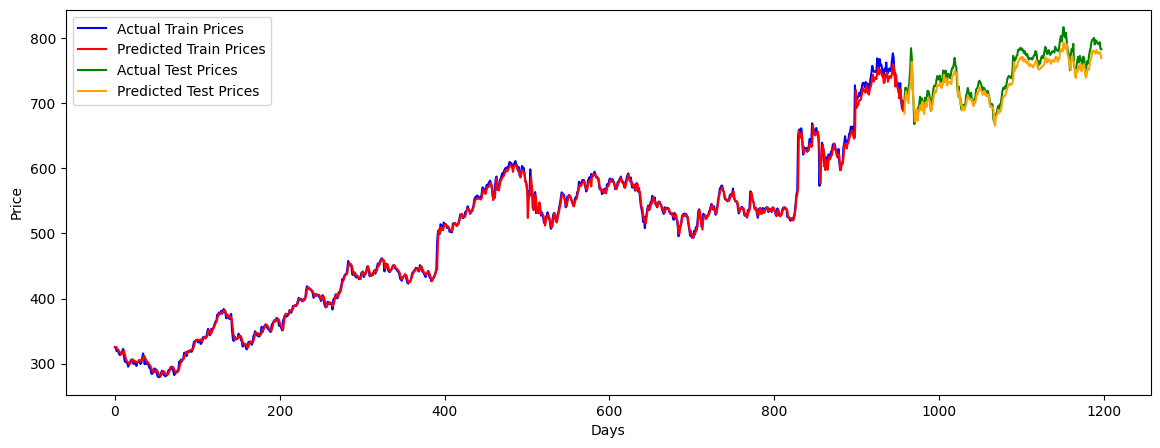

In [21]:
# Visualize the results
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_train_actual)), y_train_actual, color='blue', label='Actual Train Prices')
plt.plot(range(len(y_train_pred)), y_train_pred, color='red', label='Predicted Train Prices')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_actual)), y_test_actual, color='green', label='Actual Test Prices')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_test_pred)), y_test_pred, color='orange', label='Predicted Test Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()